# 📈 Professional Bitcoin Directional Prediction using Logistic Regression
## Optimized for hourly BTC/USDT analysis

This notebook implements a directional trading model using **Logistic Regression**. This model serves as a robust baseline and interpretable alternative to more complex algorithms.

### Objectives:
1. **Information Extraction**: Process comprehensive indicators (Technical, On-Chain, Macro, Sentiment).
2. **Dimensionality Reduction**: Identify the top Alpha generators using univariate statistical tests and correlation filters.
3. **Optimization**: Fine-tune the Logistic Regression hyperparameters (Regularization) through Time-Series aware cross-validation.
4. **Performance Evaluation**: Analyze the strategy returns through financial risk metrics (Sharpe, Drawdown).

In [1]:
# ==============================
# Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')

# ==============================
# File Path (Local)
# ==============================
FILE_PATH = "../data/features/btc_features_complete.csv"

# ==============================
# Save Model & Scaler
# ==============================
MODEL_SAVE_PATH = "../models/logistic_regression/btc_lr_hourly_model.pkl"
SCALER_SAVE_PATH = "../models/logistic_regression/btc_lr_hourly_scaler.pkl"

# ==============================
# Styling (dark + crypto)
# ==============================
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 9)

# 🎯 Palette crypto corrigée
COLORS = ['#F7931A', '#00FF9C', '#FF4C4C']

# ==============================
# Data Loading
# ==============================
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File {FILE_PATH} not found. Check the path.")

df = pd.read_csv(FILE_PATH)

print(df.head())
print(df.info())
print("Shape:", df.shape)


              Datetime      Open      High      Low     Close       Volume  \
0  2018-01-31 01:00:00   9829.99  10080.00  9700.00   9967.48  2341.104910   
1  2018-01-31 02:00:00   9967.47  10278.00  9932.46  10229.84  1162.774900   
2  2018-01-31 03:00:00  10229.77  10233.99  9967.00  10060.00   920.236009   
3  2018-01-31 04:00:00  10069.96  10089.59  9888.00   9983.76   682.356001   
4  2018-01-31 05:00:00   9985.00  10177.99  9810.00  10097.25  1008.606525   

    returns  log_returns  future_return_1h  future_return_6h  ...  nvt_ratio  \
0  0.013987     0.013890          0.026322          0.031354  ...   0.830917   
1  0.026322     0.025981         -0.016602          0.000960  ...   0.830917   
2 -0.016602    -0.016742         -0.007579          0.012971  ...   0.830917   
3 -0.007579    -0.007607          0.011367          0.028116  ...   0.830917   
4  0.011367     0.011303          0.014610          0.019094  ...   0.830917   

   fg_change_7d  extreme_fear  extreme_greed  sp50

---
## 1. Data Ingestion & Sequence Engineering
We use the comprehensive dataset generated by our production pipeline, focusing on numeric inputs and adding behavioral lags.

In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)

    # Professional Rule: Automaticaly select only numeric columns for model inputs
    df = df.select_dtypes(include=[np.number])

    print(f"Initial numeric dataset shape: {df.shape}")

    # Engineering lags for the top technical indicators
    target_lags = ['returns', 'RSI_14', 'MACDHIST', 'Close', 'Volume']
    existing_lags = [f for f in target_lags if f in df.columns]

    for f in existing_lags:
        for lag in range(1, 6):
            df[f"{f}_lag_{lag}"] = df[f].shift(lag)

    return df.ffill().bfill().dropna()

df = load_and_preprocess(FILE_PATH)
print(f"Processing complete. Total features (with lags): {len(df.columns)}")

Initial numeric dataset shape: (69861, 69)
Processing complete. Total features (with lags): 89


---
## 2. Advanced Feature Selection
Selecting variables that have the highest ANOVA F-value relative to the direction and filtering out highly correlated features to minimize redundancy.

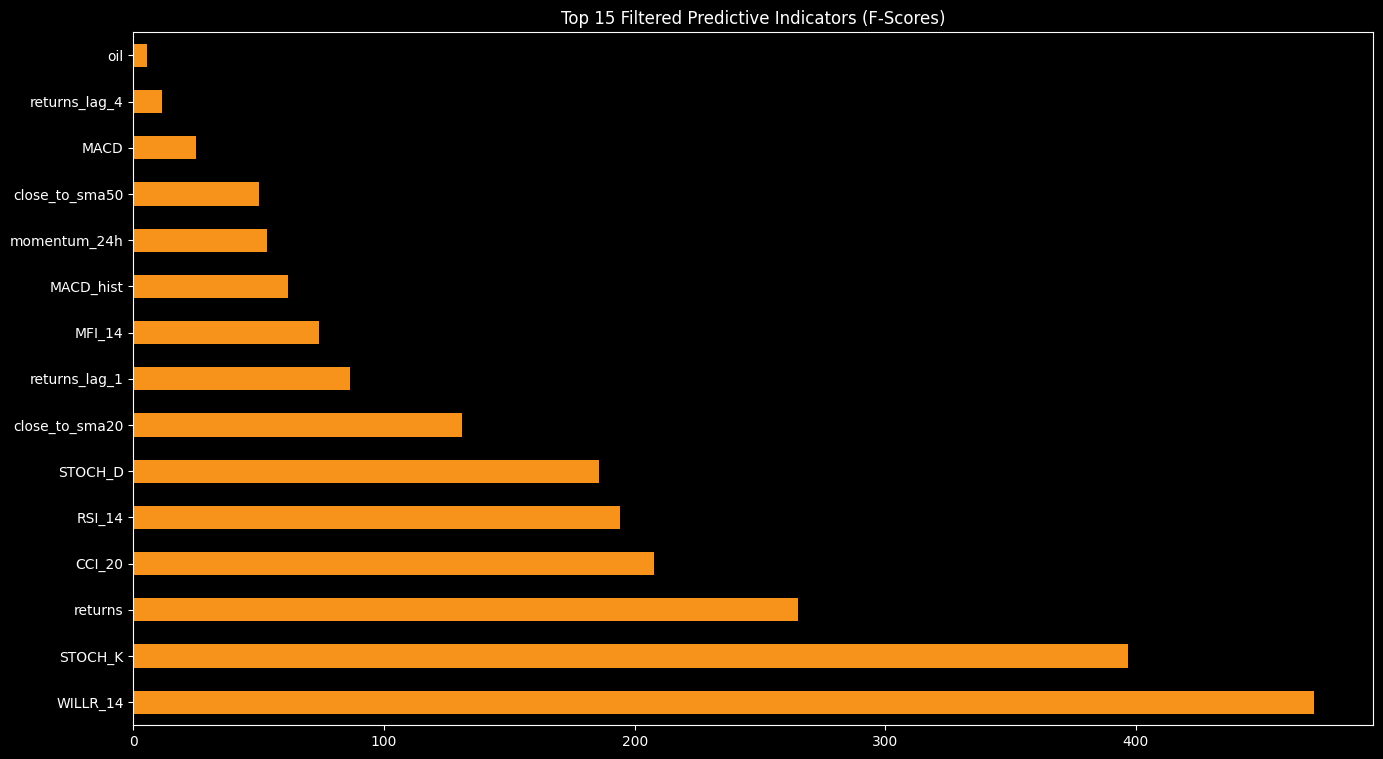

Selected Top 25 features: ['Open', 'returns', 'momentum_24h', 'MACD', 'MACD_hist']...


In [3]:
def select_features(df, k=25):
    target = 'target_direction'
    # Ensure target exists
    if target not in df.columns:
        # Create target if missing (1 if returns > 0 else 0)
        df[target] = np.where(df['returns'].shift(-1) > 0, 1, 0)
        df = df.dropna()

    X_raw = df.drop([c for c in df.columns if 'target' in c.lower() or 'future_return' in c.lower()], axis=1)
    y = df[target]

    # Univariate selection
    selector = SelectKBest(score_func=f_classif, k=min(k*2, X_raw.shape[1]))
    selector.fit(X_raw, y)
    top_raw_cols = X_raw.columns[selector.get_support()]

    # Multicollinearity Filter
    corr_matrix = X_raw[top_raw_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    final_cols = [c for c in top_raw_cols if c not in to_drop][:k]

    # Visualization
    scores = pd.Series(selector.scores_, index=X_raw.columns).loc[final_cols].sort_values(ascending=False).head(15)
    scores.plot(kind='barh', color=COLORS[0])
    plt.title('Top 15 Filtered Predictive Indicators (F-Scores)')
    plt.show()

    return final_cols

top_features = select_features(df, k=25)
print(f"Selected Top 25 features: {top_features[:5]}...")

---
## 3. Logistic Regression Model Training
Preparing the data and optimizing for regularization strength.

In [4]:
# Prepare arrays
X = df[top_features]
y = df['target_direction']

# 80% split (sequential)
cutoff = int(len(X) * 0.8)
X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train)} | Test set: {len(X_test)}")

Training set: 55888 | Test set: 13973


In [5]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # Required for L1
}

tscv = TimeSeriesSplit(n_splits=5)

print("🔍 Optimizing Logistic Regression hyperparameters...")
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

best_lr = grid_search.best_estimator_
print(f"✅ Best Parameters Found: {grid_search.best_params_}")

🔍 Optimizing Logistic Regression hyperparameters...
✅ Best Parameters Found: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


---
## 4. Evaluation & Backtesting
Comparing predictive accuracy and financial outcomes.

In [6]:
y_pred = best_lr.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"📈 Final Accuracy Score: {acc:.2%}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

📈 Final Accuracy Score: 52.66%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.52      0.61      0.56      6900
           1       0.54      0.44      0.49      7073

    accuracy                           0.53     13973
   macro avg       0.53      0.53      0.52     13973
weighted avg       0.53      0.53      0.52     13973



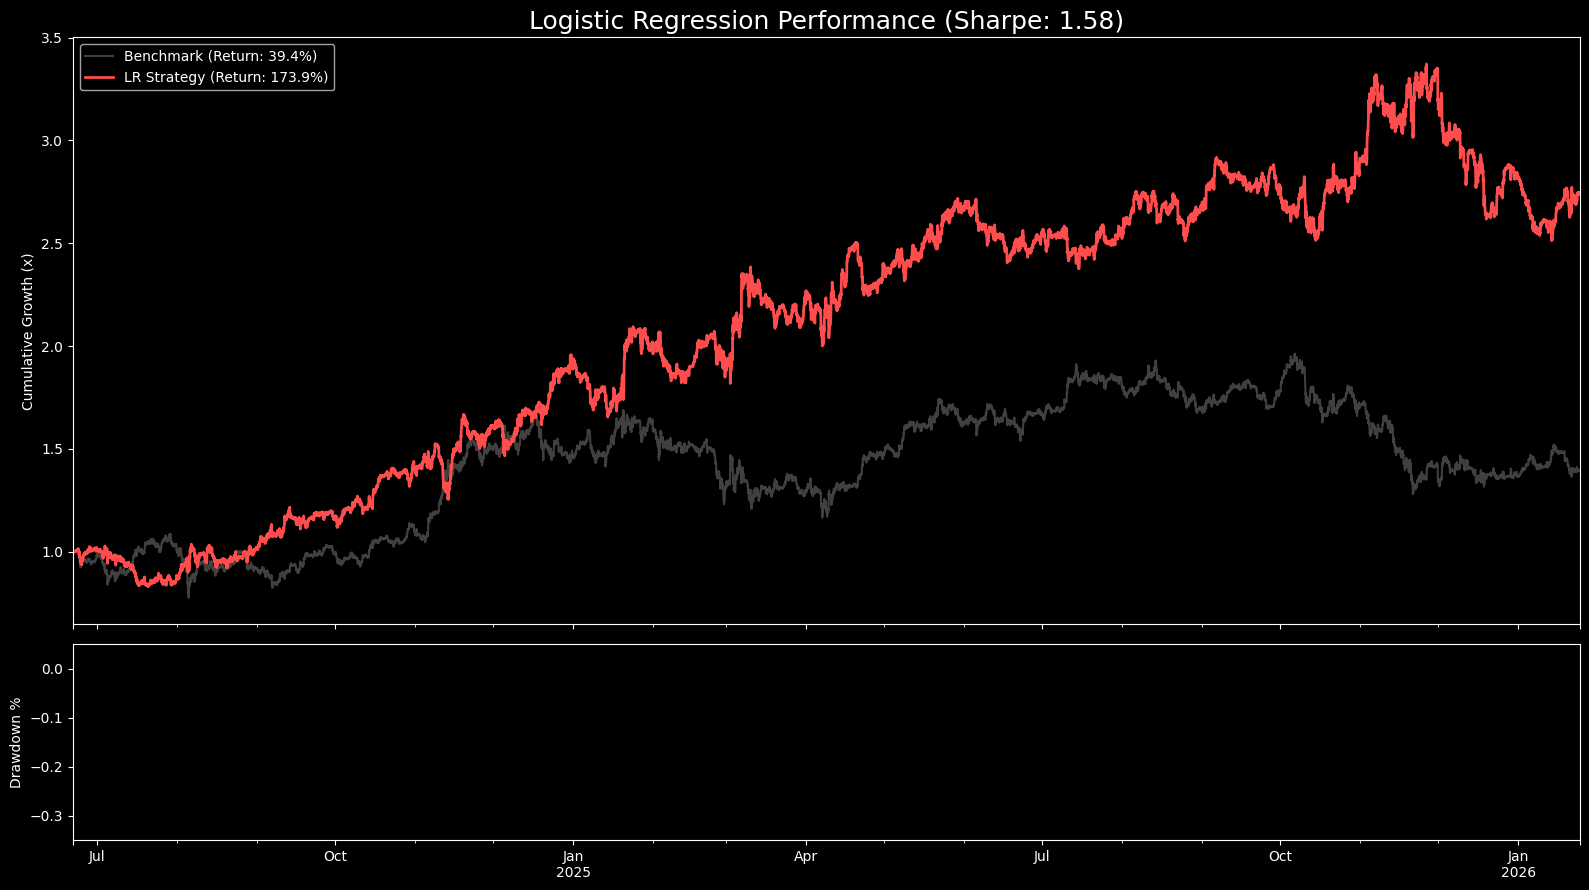


--- Strategy Performance Comparison ---
         Metric Strategy Benchmark
   Total Return   173.9%     39.4%
Ann. Volatility    46.9%     46.9%
   Sharpe Ratio     1.58      0.68
   Max Drawdown   -25.4%    -34.8%


In [7]:
def calculate_metrics(returns):
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365) if returns.std() != 0 else 0
    cum_ret = (1 + returns).cumprod()
    drawdown = cum_ret / cum_ret.cummax() - 1
    max_dd = drawdown.min()
    vol = returns.std() * np.sqrt(24 * 365)
    return sharpe, max_dd, vol, cum_ret.iloc[-1] - 1

def run_professional_backtest(y_test, y_pred, df_full):
    test_period = df_full.iloc[-len(y_test):].copy()

    test_period['signal'] = np.where(y_pred == 1, 1, -1)
    test_period['strat_ret'] = test_period['signal'].shift(1) * test_period['returns']
    test_period = test_period.dropna()

    s_sharpe, s_mdd, s_vol, s_ret = calculate_metrics(test_period['strat_ret'])
    b_sharpe, b_mdd, b_vol, b_ret = calculate_metrics(test_period['returns'])

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ((1 + test_period['returns']).cumprod()).plot(ax=ax1, label=f'Benchmark (Return: {b_ret:.1%})', color='gray', alpha=0.5)
    ((1 + test_period['strat_ret']).cumprod()).plot(ax=ax1, label=f'LR Strategy (Return: {s_ret:.1%})', color=COLORS[2], linewidth=2)
    ax1.set_title(f'Logistic Regression Performance (Sharpe: {s_sharpe:.2f})', fontsize=18)
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Cumulative Growth (x)')

    dd = (1 + test_period['strat_ret']).cumprod() / (1 + test_period['strat_ret']).cumprod().cummax() - 1
    ax2.fill_between(dd.index, dd, 0, color=COLORS[1], alpha=0.3)
    ax2.set_ylabel('Drawdown %')
    ax2.set_ylim(-0.35, 0.05)

    plt.tight_layout()
    plt.show()

    stats = pd.DataFrame({
        'Metric': ['Total Return', 'Ann. Volatility', 'Sharpe Ratio', 'Max Drawdown'],
        'Strategy': [f"{s_ret:.1%}", f"{s_vol:.1%}", f"{s_sharpe:.2f}", f"{s_mdd:.1%}"],
        'Benchmark': [f"{b_ret:.1%}", f"{b_vol:.1%}", f"{b_sharpe:.2f}", f"{b_mdd:.1%}"]
    })
    print("\n--- Strategy Performance Comparison ---")
    print(stats.to_string(index=False))

    total_trades = int((test_period['signal'].diff() != 0).sum())
    return {
        "total_return": float(s_ret),
        "annual_volatility": float(s_vol),
        "sharpe_ratio": float(s_sharpe),
        "maximum_drawdown": float(s_mdd),
        "total_trades": int(total_trades)
    }

backtest_results = run_professional_backtest(y_test, y_pred, df)

---
## 5. Persistence
Saving results for inference.

In [8]:
os.makedirs('../models/logistic_regression', exist_ok=True)
joblib.dump(best_lr, MODEL_SAVE_PATH)
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"✅ Successfully exported model to {MODEL_SAVE_PATH}")

✅ Successfully exported model to ../models/logistic_regression/btc_lr_hourly_model.pkl


In [9]:
import json
import datetime

# Prepare metadata
metadata = {
    "model_name": "Logistic Regression BTC",
    "accuracy": acc,
    "backtesting": {
        "total_return": backtest_results["total_return"],
        "annual_volatility": backtest_results["annual_volatility"],
        "sharpe_ratio": backtest_results["sharpe_ratio"],
        "maximum_drawdown": backtest_results["maximum_drawdown"],
        "win_rate": float(acc),
        "total_trades": int(backtest_results["total_trades"])
    },
    "best_params": grid_search.best_params_,
    "top_features": top_features,
    "training_size": len(X_train),
    "test_size": len(X_test),
    "export_timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Save to JSON
METADATA_SAVE_PATH = "../models/logistic_regression/btc_lr_hourly_metadata.json"
with open(METADATA_SAVE_PATH, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Successfully exported model metadata to {METADATA_SAVE_PATH}")
print(json.dumps(metadata, indent=4))

✅ Successfully exported model metadata to ../models/logistic_regression/btc_lr_hourly_metadata.json
{
    "model_name": "Logistic Regression BTC",
    "accuracy": 0.5265869891934445,
    "backtesting": {
        "total_return": 1.7389452857260697,
        "annual_volatility": 0.46868095771884016,
        "sharpe_ratio": 1.582342834809403,
        "maximum_drawdown": -0.25442866244426254,
        "win_rate": 0.5265869891934445,
        "total_trades": 2785
    },
    "best_params": {
        "C": 0.001,
        "penalty": "l2",
        "solver": "liblinear"
    },
    "top_features": [
        "Open",
        "returns",
        "momentum_24h",
        "MACD",
        "MACD_hist",
        "RSI_14",
        "STOCH_K",
        "STOCH_D",
        "ADX_14",
        "CCI_20",
        "WILLR_14",
        "MFI_14",
        "OBV",
        "close_to_sma20",
        "close_to_sma50",
        "close_to_sma200",
        "mempool_size_bytes",
        "dxy",
        "oil",
        "fear_greed_value",
